# Introduction to blockchain HW 1

## Problem 1 (10 points)

Assume that at the end of the term an instructor uses an RSA Public Key Cryptosystem to sign the grades sent to students and to the Education Office. He signs each grade with his private key and transmits both the grade and the signature in a secure manner encrypted with a public key. After you decrypt the message you use his public key to decipher the signature and verify the grade. Assume the cryptosystem has the following features: n=55, e=33 and that the grading system features integer grades from 0 to 10. You have received the grade-signature pairs 8||13 and 6||41

1.Verify that the grades you received are indeed originating from the instructor showing just intermediate results of your calculation (2 points)

- $ 8 \| 13: m = s^e\, mod\, n = [e = 33; s = 13; n = 55] = 13^{33}\, mod\, 55 = 8 $, so the signature is valid
- $ 6 \| 41: m = s^e\, mod\, n = [e = 33; s = 41; n = 55] = 41^{33}\, mod\, 55 = 6 $, so the signature is valid

2.Given the information above only can you fabricate the instructors’ signature for another grade? If yes, for which grade and how? (3 points)

The question is not 100% clear, because on the one hand is I am given with info below (like the public key) I have the following answer: <br>
- Yes, we can. Any grade, given with a public key of instructor we can calculate his private key $d$: <br>
$$ d = e ^ {-1} \, mod \, \varphi(n) = [e = 33; n = 55] = 33^{-1} \, mod \, \varphi(55) = [\varphi(55) = 40] = 17 $$ 
Then we can claim to be the instructor and sign messages, for example: <br>
$$ s = m^d \, mod\, n = [m = 8; d = 17; n = 55] = 8^{17} \, mod \, 55 = 13 $$

But if are not given with info about key and suppose that it's big enough, then teacher has to avoid signing $0$ and $1$ grades, because their signatures are the same as grades.

3.What would you advise the instructor to do so as to prevent such fabrication? (2 points)

Here the answer again depends on case we consider in previous question, in the first case the advise is the following:
- Use much bigger prime numbers $p$ and $q$ at the stage of calculating $n$ feature, such that the lenght of key will be 2048 bits. That will make the proccess of finding inverse number impractical.

In the second case:
- Shift grade scale on 2, like $0 \to 2$, $1 \to 3$, etc

4.Discuss what can go wrong in case the instructor sends a grade secretly by first enciphering it with a student’s public key, the signing it with his private key. Provide an example (3 points)

In this case we might get the case when it is not possible to verify signature, because the encrypted grade might be greater than the length of teacher private key [for certainty we consider case when $n_1$ (teacher) is lower than $n_2$ (student)]

## Problem 2 (10 points)

El-Gamal is videly used cryptographic standart. In this task you will implement El-Gamal encryption scheme using Python

1.Implement function for generating keys. The function must generate big random prime number (problem of generating big prime numbers was discussed during seminar after lecture 3). (2 points)

In [36]:
# Choose big prime number p
# Choose two random numbers g and x
# Compute y = g^x mod p
# public key - (y, g, p); private key - (x, g, p)
from math import gcd as bltin_gcd
from random import randint
import gmpy2
from functools import wraps
import math
import sympy

def is_prime(n, k):
    if n == 1:
        return False
    if k >= n:
        k = num - 1
    for i in range(k):
        a = randint(1, n - 1)
        if pow(a, n - 1, n) != 1:
            return False
    return True

def gen_prime(n, k=1000):
    found_prime = False
    while not found_prime:
        p = randint(2 ** (n - 1), 2 ** n)
        if is_prime(p, k):
            return p
        
def gen_safe_prime(n, k=1000):
    found_safe_prime = False
    while not found_safe_prime:
        p = gen_prime(n, k)
        sp = 2 * p + 1
        if (is_prime(sp, k)):
            return sp

def prim_root(p):
    found_prime_root = False
    while not found_prime_root:
        g = randint(0, p - 1)
        first_exp = 2
        second_exp = (p - 1) // 2
        if (pow(g, first_exp, p) != 1 and pow(g, second_exp, p) != 1):
            return g
        
        
def elg_key_gen(n):
    p = gen_safe_prime(n)
    g = prim_root(p)
    x = randint(2 ** (n - 1), 2 ** n)
    y = pow(g, x, p)
    return (y, g, p), (x, g, p)

2.Implement functions that implement the encryption and decryption functions. (2 points)

In [35]:
from math import gcd as bltin_gcd
from random import randint
import gmpy2

def elg_encrypt(msg, pub_key):
    y, g, p = pub_key
    k = randint(1, p - 1)
    a = pow(g, k, p)
    b = pow(y, k, p) * msg % p
    return (a, b)

def elg_decrypt(emsg, priv_key):
    a, b = emsg
    x, g, p = priv_key
    msg = b * gmpy2.invert(pow(a, x, p), p) % p
    return msg

3.Test your functions on random values and show that your implementation works correctly (1 point)

In [37]:
key_length_bits = 256
msg_orig = 0xdeadface

pub_key, priv_key = elg_key_gen(key_length_bits)
emsg = elg_encrypt(msg_orig, pub_key)
msg = elg_decrypt(emsg, priv_key)
if (msg_orig == msg):
    print("Success")
else:
    print("Something went wrong")

Success


4.Implement functions that perform creation and verification of digital signature (2 points)

In [39]:
from math import gcd as bltin_gcd
from random import randint
import gmpy2

def find_coprime(p):
    while True:
        k = randint(1, p - 1)
        if bltin_gcd(k, p):
            return k
        
def elg_sign(msg, priv_key):
    while True:
        x, g, p = priv_key
        k = find_coprime(p)
        a = pow(g, k, p)
        try:
            b = (msg - x * a) * (gmpy2.invert(k, p - 1)) % (p - 1)
            break
        except ZeroDivisionError:
            pass
    return (a, b)

def elg_verify_sign(msg, sign, pub_key):
    a, b = sign
    y, g, p = pub_key
    left_op = pow(y, a, p) * pow(a, b, p) % p
    right_op = pow(g, msg, p)
    if (left_op == right_op):
        return "OK"
    else:
        return "ERR"

5.Test your functions on random values and show that your algorithm works correctly (1 point)

In [40]:
key_length_bits = 256
msg_orig = 0xdeadface

pub_key, priv_key = elg_key_gen(key_length_bits)
signature = elg_sign(msg_orig, priv_key)
sign_verificaton = elg_verify_sign(msg_orig, signature, pub_key)
print("Signature verification result:", sign_verificaton)

Signature verification result: OK


## Problem 3 (15 points)

1.Implement SHA256 (https://en.wikipedia.org/wiki/SHA-2) hashing algorithm using the pseudo-code below. Note the great increase in mixing between bits of the w[16..63] words compared to SHA-1 (10 points)

In [279]:
def sha256(data):
    # Set of helper functions
    def chunks(data, block_size):
        return [data[i:i + block_size] for i in range(0, len(data), block_size)]

    def ror(x, n):
        return (x >> n) | (x << 32 - n) & 0xffffffff
    
    bytes = ""
    
    # Initialize hash values, such that
    # first 32 bits of the fractional
    # parts of the square roots of the first 8 primes 2..19:
    h0 = 0x6a09e667
    h1 = 0xbb67ae85
    h2 = 0x3c6ef372
    h3 = 0xa54ff53a
    h4 = 0x510e527f
    h5 = 0x9b05688c
    h6 = 0x1f83d9ab
    h7 = 0x5be0cd19
    
    # Initialize array of round constants such that
    # first 32 bits of the fractional parts of the cube
    # roots of the first 64 primes 2..311:
    k = [0x428a2f98, 0x71374491, 0xb5c0fbcf, 0xe9b5dba5, 0x3956c25b, 0x59f111f1, 0x923f82a4, 0xab1c5ed5,
         0xd807aa98, 0x12835b01, 0x243185be, 0x550c7dc3, 0x72be5d74, 0x80deb1fe, 0x9bdc06a7, 0xc19bf174,
         0xe49b69c1, 0xefbe4786, 0x0fc19dc6, 0x240ca1cc, 0x2de92c6f, 0x4a7484aa, 0x5cb0a9dc, 0x76f988da,
         0x983e5152, 0xa831c66d, 0xb00327c8, 0xbf597fc7, 0xc6e00bf3, 0xd5a79147, 0x06ca6351, 0x14292967,
         0x27b70a85, 0x2e1b2138, 0x4d2c6dfc, 0x53380d13, 0x650a7354, 0x766a0abb, 0x81c2c92e, 0x92722c85,
         0xa2bfe8a1, 0xa81a664b, 0xc24b8b70, 0xc76c51a3, 0xd192e819, 0xd6990624, 0xf40e3585, 0x106aa070,
         0x19a4c116, 0x1e376c08, 0x2748774c, 0x34b0bcb5, 0x391c0cb3, 0x4ed8aa4a, 0x5b9cca4f, 0x682e6ff3,
         0x748f82ee, 0x78a5636f, 0x84c87814, 0x8cc70208, 0x90befffa, 0xa4506ceb, 0xbef9a3f7, 0xc67178f2]

    # Pre-processing (Padding):
    # begin with the original message of length L bits
    # append a single '1' bit
    for n in range(len(data)):
        bytes += '{0:08b}'.format(ord(data[n]))
    bits = bytes + "1"
    pBits = bits
    # append K '0' bits, where K is the minimum number >= 0
    # such that L + 1 + K + 64 is a multiple of 512
    while (len(pBits) + 64) % 512 != 0:
        pBits += "0"
    # append L as a 64-bit big-endian integer, making
    # the total post-processed length a multiple of 512 bits
    pBits += '{0:064b}'.format(len(bits) - 1)

    # Process the message in successive 512-bit chunks:     
    for block in chunks(pBits, 512):
        #print(block)
        #print(len(block))
        # create a 64-entry message schedule array w[0..63] of 32-bit words
        w = [0 for x in range(64)]
        # copy chunk into first 16 words w[0..15] of the message schedule array
        words = chunks(block, 32)
        for n in range(len(words)):
            w[n] = int(words[n], 2)
        # extend the first 16 words into the remaining 48 words
        # w[16..63] of the message schedule array:
        for i in range(16, 64):
            s0 = ror(w[i - 15], 7) ^ ror(w[i - 15], 18) ^ (w[i - 15] >> 3)
            s1 = ror(w[i - 2], 17) ^ ror(w[i - 2], 19) ^ (w[i - 2] >> 10)
            w[i] = w[i - 16] + s0 + w[i - 7] + s1 & 0xffffffff
            
        # Initialize working variables to current hash value:
        a, b, c, d, e, f, g, h = h0, h1, h2, h3, h4, h5, h6, h7

        # Compression function main loop            
        for i in range(0, 64):
            S1 = ((ror(e, 6) ^ ror(e, 11) ^ ror(e, 25)))
            ch = (e & f) ^ ((~e) & g)
            temp1 = ((h + S1 + ch + k[i] + w[i] ))
            S0 = (ror(a, 2) ^ ror(a, 13) ^ ror(a, 22))
            maj = ((a & b) ^ (a & c) ^ (b & c))
            temp2 = (S0 + maj)
            
            h, g, f, e, d, c, b, a = g, f, e, d + temp1 & 0xffffffff, c, b, a, temp1 + temp2 & 0xffffffff

        # Add the compressed chunk to the current hash value:
        h0 = h0 + a & 0xffffffff
        h1 = h1 + b & 0xffffffff
        h2 = h2 + c & 0xffffffff
        h3 = h3 + d & 0xffffffff
        h4 = h4 + e & 0xffffffff
        h5 = h5 + f & 0xffffffff
        h6 = h6 + g & 0xffffffff
        h7 = h7 + h & 0xffffffff

    return '%08x%08x%08x%08x%08x%08x%08x%08x' % (h0, h1, h2, h3, h4, h5, h6, h7)

2.Calculate hashes of the texts below (1 point)

In [42]:
string_small = 'This is a very small string with a few characters.'
string_larger = 'This is a larger string that contains more characters.'
string_big = 'This is a larger string that contains more characters. This demonstrates that no matter how big the input stream is, the generated hash is the same size (but of course, not the same value). If two files have a different hash, they surely contain different data.'
string_empty = ''

In [43]:
print(sha256(string_small))
print(sha256(string_larger))
print(sha256(string_big))
print(sha256(string_empty))

551bfc4b109bec23bbf29ba0e8c4520f194ae77d0c1839b052552deb23774f07
e3c7ba4a5ff68765249cc065a5198b1b8be94b67910a946f1fbaa995daecb51a
14d7885558ff807137a02f6b610df0e680e34ebf5a2565d44e138443fb82e891
e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855


3.What is a bit length of each hash? (1 point)

In [44]:
# 64 hex values, each hex value represents 4 bits
print(4 * len(sha256(string_small)))
print(4 * len(sha256(string_larger)))
print(4 * len(sha256(string_big)))
print(4 * len(sha256(string_empty)))

256
256
256
256


4.What is the bitwise distance between them? What is bitwise distance between their hashes? (1 point)

In [297]:
def bitwise_distance(str1, str2):
    bits1 = ''
    bits2 = ''
    diff = 0
    if (len(str1) == len(str2) == 0):
        return 0
    
    for n in range(len(str1)):
        bits1 += '{0:08b}'.format(ord(str1[n]))
    for n in range(len(str2)):
        bits2 += '{0:08b}'.format(ord(str2[n]))
    n = max(len(bits1), len(bits2))

    while (len(bits1)) % n != 0 or len(bits1) == 0:
        bits1 += "0"
    while (len(bits2)) % n != 0 or len(bits2) == 0:
        bits2 += "0"
    
    for i in range(len(bits1)):
        if (bits1[i] != bits2[i]):
            diff += 1
    return diff

def hamming2(str1, str2):
    bits1 = ''
    bits2 = ''
    for n in range(len(str1)):
        bits1 += '{0:04b}'.format(int(str1[n], 16))
    for n in range(len(str2)):
        bits2 += '{0:04b}'.format(int(str2[n], 16))
    """Calculate the Hamming distance between two bit strings"""
    return sum(c1 != c2 for c1, c2 in zip(bits1, bits2))

string = [string_small, string_larger, string_big, string_empty]

for i, substr1 in enumerate(string):
    for substr2 in string[i:len(string)]:
        if (substr1 == substr2):
            continue
        print("--------------------------------------------------------------------------------------------")
        print("String1: %.70s" % substr1)
        print("String2: %.70s" % substr2)
        print("Bitwise difference between strings: %5d" % bitwise_distance(substr1, substr2))
        print("Bitwise difference between hashes:  %5d" % hamming2(sha256(substr1), sha256(substr2)))

--------------------------------------------------------------------------------------------
String1: This is a very small string with a few characters.
String2: This is a larger string that contains more characters.
Bitwise difference between strings:   125
Bitwise difference between hashes:    142
--------------------------------------------------------------------------------------------
String1: This is a very small string with a few characters.
String2: This is a larger string that contains more characters. This demonstrat
Bitwise difference between strings:   858
Bitwise difference between hashes:    119
--------------------------------------------------------------------------------------------
String1: This is a very small string with a few characters.
String2: 
Bitwise difference between strings:   178
Bitwise difference between hashes:    130
--------------------------------------------------------------------------------------------
String1: This is a larger string that cont

5.Typically use apply hash function to our passwords and texts that we want to digitally sign. Implement digital signature of hashed string using El-Gamal digital signature. Compare the digital signature of plain text and hashed text. (2 points)

In [49]:
def str2num(data):
    res = 0
    for n in range(len(data)):
        res += (2 ** (n * 8)) * ord(data[n])
    return res    
    
msg = "easy-peasy"
msg_num = str2num(msg)
hash_val = int(sha256(msg), 16)
key_length_bits = 256

pub_key, priv_key = elg_key_gen(key_length_bits)
print("Calculate the signature of hashed message")
sign_hash = elg_sign(hash_val, priv_key)
print(sign_hash)
print("Calculate the signature of message itself")
sign_msg = elg_sign(msg_num, priv_key)
print(sign_msg)

Calculate the signature of hashed message
(16236922513965779000898260343447375970655275620038384347380948739081439302959, mpz(51199310704580199220499082505764066468708334373290948673621692187619251540645))
Calculate the signature of message itself
(38953250258535840560830254700758246980626142137186899450589987919510529710295, mpz(640402180669161739398760397173236793420028014462861682933010304778850450933))


## Problem 4 (15 points)

Merkle hash trees play an important role in forming transaction blocks in blockchain. In this assignment we ask you to plot your own Merkle hash tree and check its' properties. Below we provide you with some code fragment what you can use in your assignment

In [2]:
import matplotlib
import networkx as nx
%matplotlib qt5
%matplotlib inline
from networkx import balanced_tree, draw_networkx, draw

Let us plot graph basis for Merkle hash tree

{0: Text(0,4,"b'0'"),
 1: Text(-2,3,"b'1'"),
 2: Text(2,3,"b'2'"),
 3: Text(-3,2,"b'3'"),
 4: Text(-1,2,"b'4'"),
 5: Text(1,2,"b'5'"),
 6: Text(3,2,"b'6'"),
 7: Text(-3,1,"b'tx1'"),
 8: Text(-1,1,"b'tx2'"),
 9: Text(1,1,"b'tx3'"),
 10: Text(3,1,"b'tx4'")}

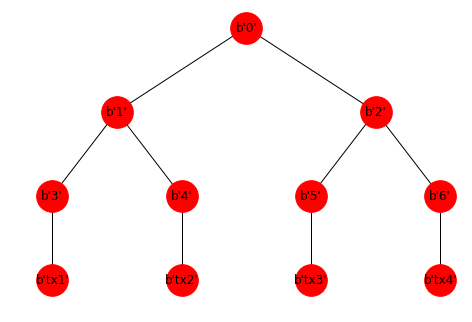

In [3]:
G = nx.Graph()
positions = {}
coordinates = [
    [0, 4],
    [-2, 3],
    [2, 3],
    [-3, 2],
    [-1, 2],
    [1, 2],
    [3, 2],
    [-3, 1],
    [-1, 1],
    [1, 1],
    [3, 1]
]
parents = [0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6]
for index in range(11):
    G.add_node(index)
    G.add_edge(index, parents[index])
    positions[index] = coordinates[index]
nx.draw(G, coordinates, node_size = 1000)
labels = {
    0: b'0',
    1: b'1',
    2: b'2',
    3: b'3',
    4: b'4',
    5: b'5',
    6: b'6',
    7: b'tx1',
    8: b'tx2',
    9: b'tx3',
    10: b'tx4',
}
nx.draw_networkx_labels(G, positions, labels = labels)

In Bitcoin double sha256 hash scheme is used. Here is an example.

In [4]:
import hashlib


first_hash = hashlib.sha256(b"hello") # "b" stands for binary representation
second_hash = hashlib.sha256()
print('First hash represented as a hexadecimal number:', first_hash.hexdigest())
second_hash.update(first_hash.digest())
print('Second hash represented as a hexadecimal number:', second_hash.hexdigest())

First hash represented as a hexadecimal number: 2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824
Second hash represented as a hexadecimal number: 9595c9df90075148eb06860365df33584b75bff782a510c6cd4883a419833d50


Now we can easily change vertices' labels to hashes of corresponding messages and plot new graph

856a4921cd32690244af7568e7bd1391a94119e17c7f33234f4bf11271b223e5


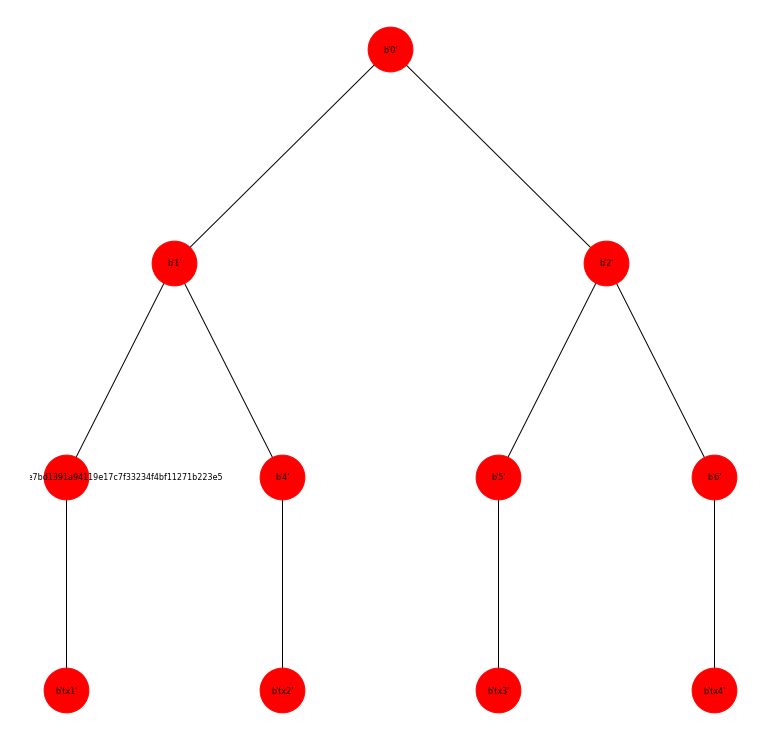

In [5]:
import matplotlib.pyplot as plt
labels[3] = hashlib.sha256(hashlib.sha256(b"tx1").digest()).hexdigest()

# and plot the graph again

plt.figure(figsize=(10,10)) 
nx.draw(G, positions, node_size = 2000)
nx.draw_networkx_labels(G, positions, labels = labels, font_size = 8)
print(labels[3])

1.Construct Merkle hash tree using previously constructed graph by finding corresponding SHA256 hashes on vertices (2 points). Plot obtained Merkle hash tree (1 point)

{0: Text(0,4,'773bc304a3b'),
 1: Text(-2,3,'f8f28ede979'),
 2: Text(2,3,'850cf301915'),
 3: Text(-3,2,'709b55bd3da'),
 4: Text(-1,2,'27ca64c092a'),
 5: Text(1,2,'1f3cb18e896'),
 6: Text(3,2,'41b637cfd9e'),
 7: Text(-3,1,"b'tx1'"),
 8: Text(-1,1,"b'tx2'"),
 9: Text(1,1,"b'tx3'"),
 10: Text(3,1,"b'tx4'")}

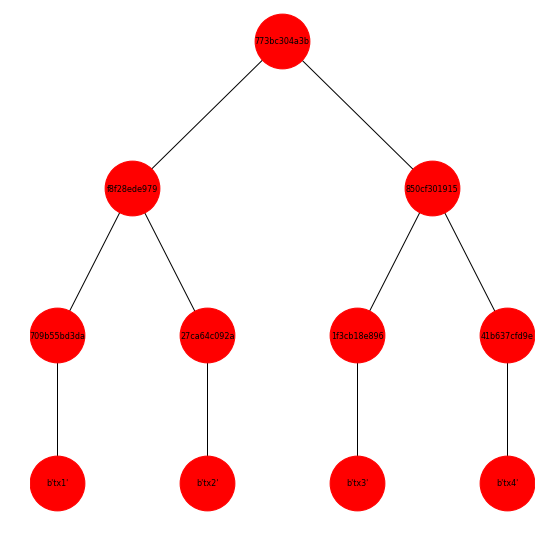

In [6]:
#labels[3] = hashlib.sha256(hashlib.sha256(b"tx1").digest()).hexdigest()

# and plot the graph again

def do_merkle_tree(parents, labels):
    marks = [0 for x in range(len(parents))]

    for node, parent in reversed(list(enumerate(parents))):
        if node not in parents:
            labels[parents[node]] = hashlib.sha256(labels[node]).hexdigest()
            marks[parents[node]] = 1
            continue
        if (marks[node] == 0):
            if (len(labels[node]) == 64):
                continue
            index = sorted([i for i, x in enumerate(parents) if (x == node)])
            str_to_be_hashed = ''
            fail = False
            for children in index:
                if (children == 0):
                    continue
                if (len(labels[children]) < 64):
                    fail = True
                    break
                str_to_be_hashed += labels[children]
            if (fail == True):
                continue
            else:
                labels[node] = hashlib.sha256(str_to_be_hashed.encode('utf-8')).hexdigest()
                marks[node] = 1
    return labels

labels = do_merkle_tree(parents, labels)
labels_short = {}
for key in labels:
    labels_short[key] = labels[key][:11]
    
plt.figure(figsize=(7,7)) 
nx.draw(G, positions, node_size = 3000)
nx.draw_networkx_labels(G, positions, labels = labels_short, font_size = 8)

2.Provide a proof of correctness of leaf tx2 (2 points). 

In [7]:
hash1 = hashlib.sha256(b'tx2').hexdigest() # hash of tx2
hash0 = labels[3] # hash of tx1
hash2 = labels[2] # hash of the right part of tree
hash3 = labels[0] # root hash

hash01 = hashlib.sha256((hash0 + hash1).encode('utf-8')).hexdigest()
hash012 = hashlib.sha256((hash01 + hash2).encode('utf-8')).hexdigest()
if (hash012 == hash3):
    print("Success")

Success


3.Provide a proof of correctness for set of leafs (tx3-tx4) (2 points)

In [8]:
hash0 = hashlib.sha256(b'tx3').hexdigest() # hash of tx3
hash1 = hashlib.sha256(b'tx4').hexdigest() # hash of tx4
hash2 = labels[1] # hash of the left part of tree
hash3 = labels[0] # root hash

hash01 = hashlib.sha256((hash0 + hash1).encode('utf-8')).hexdigest()
hash012 = hashlib.sha256((hash2 + hash01).encode('utf-8')).hexdigest()
if (hash012 == hash3):
    print("Success")

Success


4.Change the value on leaf tx1 and recompute corresponding hashes. Plot newly obtained Merkle hash tree (2 points)

{0: Text(0,4,'85a940476b2'),
 1: Text(-2,3,'5a887e684bc'),
 2: Text(2,3,'850cf301915'),
 3: Text(-3,2,'aefe99f1234'),
 4: Text(-1,2,'27ca64c092a'),
 5: Text(1,2,'1f3cb18e896'),
 6: Text(3,2,'41b637cfd9e'),
 7: Text(-3,1,"b'tx12'"),
 8: Text(-1,1,"b'tx2'"),
 9: Text(1,1,"b'tx3'"),
 10: Text(3,1,"b'tx4'")}

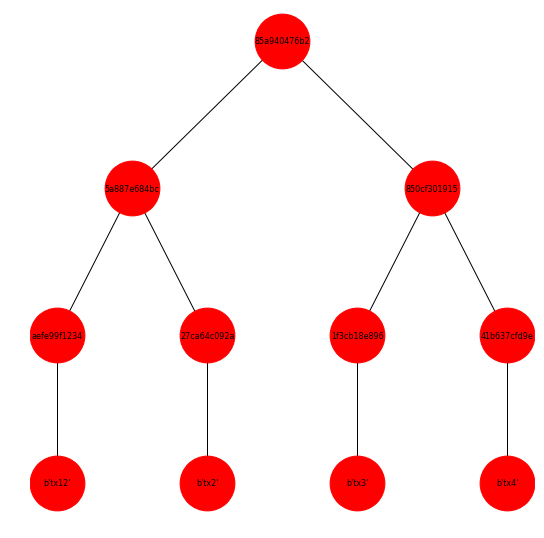

In [9]:
labels = {
    0: b'0',
    1: b'1',
    2: b'2',
    3: b'3',
    4: b'4',
    5: b'5',
    6: b'6',
    7: b'tx12',
    8: b'tx2',
    9: b'tx3',
    10: b'tx4',
}

labels = do_merkle_tree(parents, labels)
labels_short = {}
for key in labels:
    labels_short[key] = labels[key][:11]
    
plt.figure(figsize=(7,7)) 
nx.draw(G, positions, node_size = 3000)
nx.draw_networkx_labels(G, positions, labels = labels_short, font_size = 8)

5.Nodes in Merkle hash trees may have arbitrary fanout. In previouse items we consider the case of fanout equals to two. But what will change if we set a fanout equals to three? Construct Merkle hash trees with fanout 3 to sign 9 values? Construct the hash tree with fanout 2 to sign the same set of values? Plot obtained trees (4 points) 

If we change fanout to 3 in the previous case we might decrease the number of hashes calculations in some cases, like in the following case:

{0: Text(0,4,"b'0'"),
 1: Text(-2,3,"b'1'"),
 2: Text(0,3,"b'2'"),
 3: Text(2,3,"b'3'"),
 4: Text(-3,2,"b'4'"),
 5: Text(-1,2,"b'5'"),
 6: Text(0,2,"b'tx3'"),
 7: Text(2,2,"b'tx4'"),
 8: Text(-3,1,"b'tx1'"),
 9: Text(-1,1,"b'tx2'")}

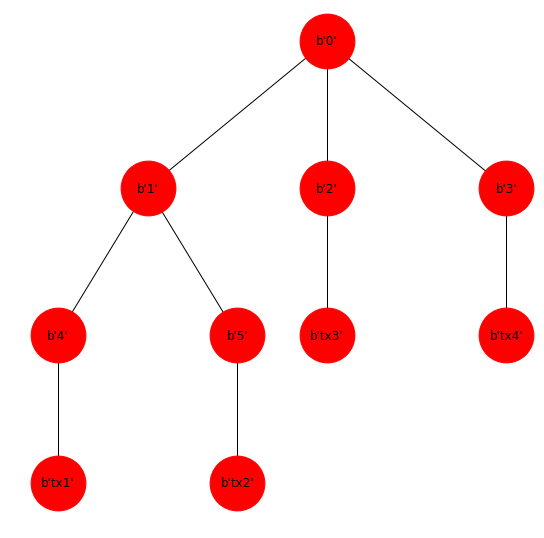

In [10]:
G = nx.Graph()
positions = {}
coordinates = [
    [0, 4],
    [-2, 3],
    [0, 3],
    [+2, 3],
    [-3, 2],
    [-1, 2],
    [0, 2],
    [+2, 2],
    [-3, 1],
    [-1, 1]
]
parents = [0, 0, 0, 0, 1, 1, 2, 3, 4, 5]
for index in range(10):
    G.add_node(index)
    G.add_edge(index, parents[index])
    positions[index] = coordinates[index]
plt.figure(figsize=(7,7))
nx.draw(G, coordinates, node_size = 3000)
labels = {
    0: b'0',
    1: b'1',
    2: b'2',
    3: b'3',
    4: b'4',
    5: b'5',
    6: b'tx3',
    7: b'tx4',
    8: b'tx1',
    9: b'tx2',
}
nx.draw_networkx_labels(G, positions, labels = labels)

Here while checking 'tx3' we need to calculate hash of 'tx3' and concatenate it with '1' and '3' and compare with '0'. The amount of hash calculations is 2 compared to 3 in the first configuration with fanout 2.

Now let's try to construct merkle tree with fanout 3 and 9 values.

{0: Text(0,4,"b'0'"),
 1: Text(-3,3,"b'1'"),
 2: Text(0,3,"b'2'"),
 3: Text(3,3,"b'3'"),
 4: Text(-4,2,"b'4'"),
 5: Text(-3,2,"b'5'"),
 6: Text(-2,2,"b'6'"),
 7: Text(-1,2,"b'7'"),
 8: Text(0,2,"b'8'"),
 9: Text(1,2,"b'9'"),
 10: Text(2,2,"b'10'"),
 11: Text(3,2,"b'11'"),
 12: Text(4,2,"b'12'"),
 13: Text(-4,1,"b'tx1'"),
 14: Text(-3,1,"b'tx2'"),
 15: Text(-2,1,"b'tx3'"),
 16: Text(-1,1,"b'tx4'"),
 17: Text(0,1,"b'tx5'"),
 18: Text(1,1,"b'tx6'"),
 19: Text(2,1,"b'tx7'"),
 20: Text(3,1,"b'tx8'"),
 21: Text(4,1,"b'tx9'")}

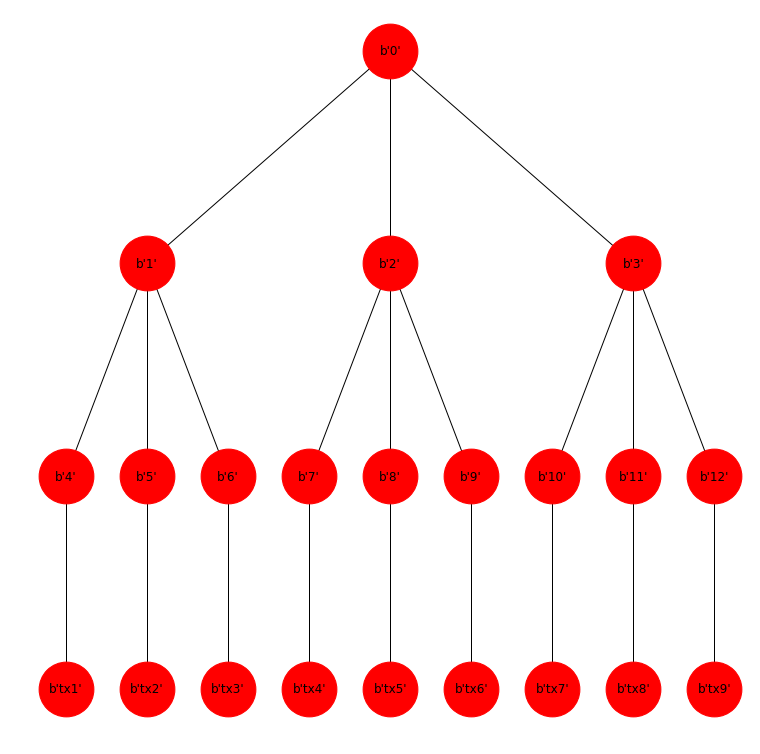

In [11]:
G = nx.Graph()
positions = {}
coordinates = [
    [0, 4],
    [-3, 3], [0, 3], [+3, 3],
    [-4, 2], [-3, 2], [-2, 2], [-1, 2], [0, 2], [1, 2], [2, 2], [3, 2], [4, 2],
    [-4, 1], [-3, 1], [-2, 1], [-1, 1], [0, 1], [1, 1], [2, 1], [3, 1], [4, 1]
]
parents = [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for index in range(22):
    G.add_node(index)
    G.add_edge(index, parents[index])
    positions[index] = coordinates[index]
plt.figure(figsize=(10,10))
nx.draw(G, coordinates, node_size = 3000)
labels = {
    0: b'0',
    1: b'1',
    2: b'2',
    3: b'3',
    4: b'4',
    5: b'5',
    6: b'6',
    7: b'7',
    8: b'8',
    9: b'9',
    10: b'10',
    11: b'11',
    12: b'12',
    13: b'tx1',
    14: b'tx2',
    15: b'tx3',
    16: b'tx4',
    17: b'tx5',
    18: b'tx6',
    19: b'tx7',
    20: b'tx8',
    21: b'tx9'
}
nx.draw_networkx_labels(G, positions, labels = labels)

In that configuration to check any of trX we need to calculate hash of it and concatenate with two neighboring, then calculate hash of it and concat with two neighboring and compare with root hash. So here we need to perform 3 hash calculations and 5 requests (including root).

If we consider 9 values in the tree with fanout 2 we will get 4 requests and 3 hash calculations but in one case 5 requests and 4 hash calculations. So in terms of number of requests the configuration with fanout 3 is worse but in terms of number of hash calculations is appr. the same on average.

{0: Text(0,4,"b'0'"),
 1: Text(-4,3,"b'1'"),
 2: Text(4,3,"b'2'"),
 3: Text(-8,2,"b'3'"),
 4: Text(-4,2,"b'4'"),
 5: Text(4,2,"b'5'"),
 6: Text(8,2,"b'6'"),
 7: Text(-12,1,"b'7'"),
 8: Text(-8,1,"b'tx3'"),
 9: Text(-4,1,"b'tx4'"),
 10: Text(0,1,"b'tx5'"),
 11: Text(4,1,"b'tx6'"),
 12: Text(8,1,"b'tx7'"),
 13: Text(12,1,"b'tx8'"),
 14: Text(16,1,"b'tx9'"),
 15: Text(-14,0,"b'tx1'"),
 16: Text(-10,0,"b'tx2'")}

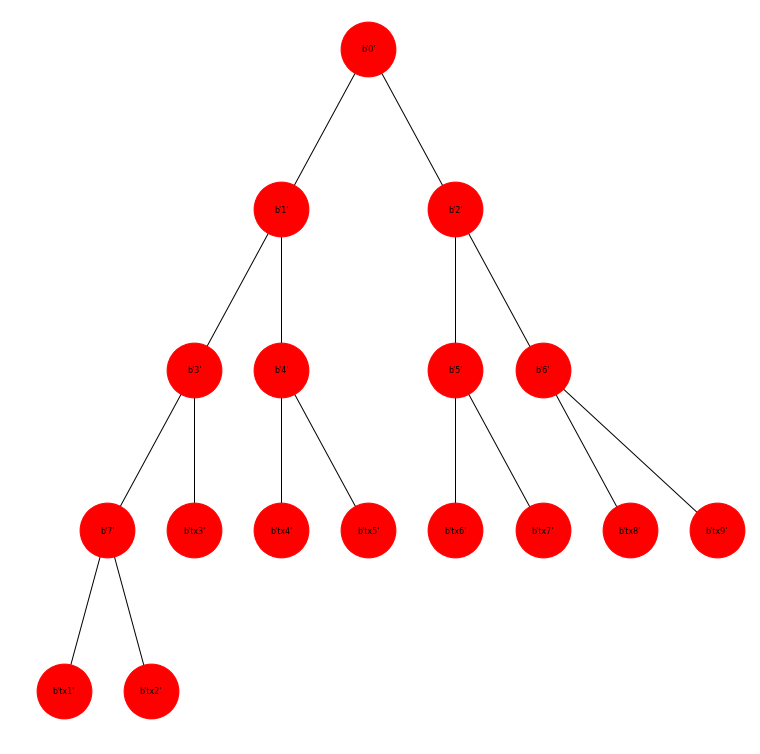

In [20]:
G = nx.Graph()
positions = {}
coordinates = [
    [0, 4],
    [-4, 3], [+4, 3], [-8, 2], [-4, 2], [+4, 2], [+8, 2],
    [-12,1], [-8, 1], [-4, 1], [0, 1], [+4, 1], [+8, 1], [+12, 1], [+16, 1],
    [-14, 0], [-10, 0]
]
parents = [0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7] + list(range(8, 17))
for index in range(17):
    G.add_node(index)
    G.add_edge(index, parents[index])
    positions[index] = coordinates[index]
plt.figure(figsize=(10,10))
nx.draw(G, coordinates, node_size = 3000)

labels = {
    0: b'0',
    1: b'1',
    2: b'2',
    3: b'3',
    4: b'4',
    5: b'5',
    6: b'6',
    7: b'7',
    8: b'tx3',
    9: b'tx4',
    10: b'tx5',
    11: b'tx6',
    12: b'tx7',
    13: b'tx8',
    14: b'tx9',
    15: b'tx1',
    16: b'tx2'
}

nx.draw_networkx_labels(G, positions, labels = labels, font_size = '8')

6.What is the optimum tree fanout for signing first 4 values in the set up of previouse item? (2 points)

In terms of number of hash calculations the optimal fanout is 9, because we need to make just 5 hash calculations to verify them (4 for transactions itself and 1 for root). Any additional layer in tree will cause additional number of hash calculations to be done.